In [5]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm


In [6]:
print(data)

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.8374862e-09
 -3.1501399e-09 -4.5060791e-09]


In [7]:
print(example_bark)

DataSet/1.family/001.m4a


In [8]:
current_directory = 'DataSet/'

fulldatasetpath = current_directory
metadata = pd.read_csv('file_info_miss_1.csv')
print(fulldatasetpath)

DataSet/


In [9]:
metadata.head()

,folder,filename,class
0,1.family,001.m4a,1
1,1.family,002.m4a,1
2,1.family,003.m4a,1
3,1.family,004.m4a,1
4,1.family,005.m4a,1


In [10]:
import numpy as np


def extract_features(file_name):

    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
        mfccsscaled = np.mean(mfccs.T,axis=0)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccsscaled

In [11]:
features = []
# This process will be a bit slow because it's single threaded
for index, row in tqdm(metadata.iterrows(), total=metadata.__len__()):
    file_name = str(current_directory) + str(row["folder"]) + "/"+ str(row["filename"])
    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])
# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files')

  0%|          | 0/11138 [00:00<?, ?it/s]C:\Users\humza\AppData\Local\Temp\ipykernel_21452\4029842003.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name)
c:\Users\humza\Anaconda3\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████| 11138/11138 [16:46<00:00, 11.06it/s]


Finished feature extraction from  11138  files


In [12]:
featuresdf.head()

,feature,class
0,"[-421.10275, 78.50895, 13.353661, 9.484657, 16...",1
1,"[-400.56213, 111.33991, 23.567688, 22.711441, ...",1
2,"[-379.65155, 125.1432, -0.29079124, 19.870483,...",1
3,"[-328.57935, 130.68114, -4.098667, 8.577348, -...",1
4,"[-336.47913, 134.46141, -5.6406884, 16.054068,...",1


In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
class_list = featuresdf['class']
y = np.array(class_list.tolist())

'''# Encode the classification labels
le = LabelEncoder()
yy = keras.utils.to_categorical(le.fit_transform(y))'''

'# Encode the classification labels\nle = LabelEncoder()\nyy = keras.utils.to_categorical(le.fit_transform(y))'

In [14]:
print(len(X))
print(X.shape)
print(y.shape)

11138
(11138, 50)
(11138,)


In [15]:
# Get unique values and their counts
unique_values, counts = np.unique(y, return_counts=True)

# Print the result
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} times")


0: 1161 times
1: 9977 times


In [16]:
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

# Create a dictionary mapping class indices to their respective weights
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

Class weights: [4.79672696 0.55818382]
Class weights dictionary: {0: 4.796726959517657, 1: 0.5581838227924226}


In [17]:
# split the dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [18]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
num_labels = 1
filter_size = 2

# Construct model
model = Sequential()

model.add(Dense(256, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

In [19]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [20]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13056     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 15
num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='model/weights.hdf5',
#                                verbose=1, save_best_only=True)
start = datetime.now()

graph = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, verbose=1,validation_split=0.2,class_weight=class_weights_dict)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/15
223/223 [==============================] - 2s 5ms/step - loss: 6.3599 - accuracy: 0.7071 - val_loss: 0.6611 - val_accuracy: 0.8844
Epoch 2/15
223/223 [==============================] - 1s 4ms/step - loss: 1.3088 - accuracy: 0.8436 - val_loss: 0.1664 - val_accuracy: 0.9428
Epoch 3/15
223/223 [==============================] - 1s 5ms/step - loss: 0.6016 - accuracy: 0.8830 - val_loss: 0.3043 - val_accuracy: 0.8726
Epoch 4/15
223/223 [==============================] - 1s 4ms/step - loss: 0.3589 - accuracy: 0.8951 - val_loss: 0.1233 - val_accuracy: 0.9602
Epoch 5/15
223/223 [==============================] - 1s 5ms/step - loss: 0.2776 - accuracy: 0.9084 - val_loss: 0.1505 - val_accuracy: 0.9613
Epoch 6/15
223/223 [==============================] - 1s 5ms/step - loss: 0.2068 - accuracy: 0.9205 - val_loss: 0.1375 - val_accuracy: 0.9658
Epoch 7/15
223/223 [==============================] - 1s 5ms/step - loss: 0.1972 - accuracy: 0.9209 - val_loss: 0.1143 - val_accuracy: 0.9652
Epoch 

In [22]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_test, y_test, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.9883303642272949


In [23]:
y_hat = model.predict(pd.DataFrame(x_test))
y_hat

70/70 [==============================] - 0s 2ms/step


array([[1.        ],
       [0.88436085],
       [0.9995731 ],
       ...,
       [0.8553359 ],
       [0.9953507 ],
       [0.9999621 ]], dtype=float32)

In [24]:
import numpy as np

def transform_and_round(array_2d):
    # Flatten the 2D array to 1D
    array_1d = array_2d.flatten()

    # Round off all values in the 1D array
    rounded_array = np.round(array_1d)

    return rounded_array

In [25]:
y_pred = transform_and_round(y_hat)
y_pred

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       225
           1       0.99      0.99      0.99      2003

    accuracy                           0.99      2228
   macro avg       0.96      0.97      0.97      2228
weighted avg       0.99      0.99      0.99      2228



In [27]:
featuresdf.to_csv("features.csv")

In [28]:
training_accuracy=graph.history['accuracy']
print(training_accuracy)

[0.7070707082748413, 0.8435746431350708, 0.8829966187477112, 0.895061731338501, 0.9083894491195679, 0.9204545617103577, 0.9208754301071167, 0.9329405426979065, 0.9368686676025391, 0.9445847272872925, 0.9447250366210938, 0.9541245698928833, 0.9524410963058472, 0.9609988927841187, 0.9579124450683594]


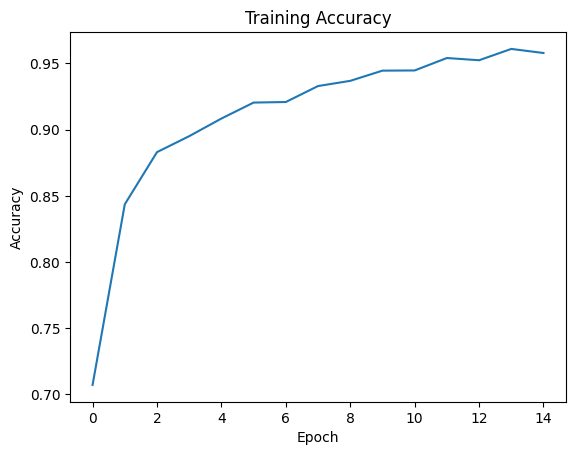

In [29]:
# Plot the training accuracy
plt.plot(training_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()